In [1]:
%matplotlib inline

In [2]:
plt.rc('font', size=15)

In [3]:
from scipy.linalg import expm
from innov import *

np.set_printoptions(precision=4, linewidth=200)

# Using jax

In [4]:
import jax.numpy as jnp
from jax import jit as jaxjit

In [7]:
@jaxjit
def construct_propagator(n, G, ro, rd, I, alpha, Q, L):
    """Construct propagator that will take occupancy number forward a small time step.
    From the linearized form
    
    n_{t+1} = (1 + \dot{n}_t / n_t * dt) n_t

    Parameters
    ----------
    n : ndarray
    G : float
    ro : float
    rd : float
    I : float
    alpha : float
    Q : float
    L : float, None
    dt : float
    """
    re = 1
    
    # startup rate
    A = jnp.eye(n.size) * G/L / n
    rows, cols = jnp.diag_indices_from(A)

    # innovation shift
    A = A.at[jnp.diag_indices(n.size)].set(A[jnp.diag_indices(n.size)] - re * I * n[0]**alpha)
    A = A.at[(rows[1:],cols[:-1])].set(A[(rows[1:],cols[:-1])] + re * I * n[0]**alpha * n[:-1] / n[1:])

    # mimetic replication
    A = A.at[(rows[:-1],cols[1:])].set(A[(rows[:-1],cols[1:])] + re / (Q-1) * n[1:] / n[:-1])

    # death
    A = A.at[jnp.diag_indices(n.size)].set(A[jnp.diag_indices(n.size)] - rd)

    return A

In [8]:
G, ro, rd, I = list(iplot.iwai_params().values())[:4]
L = ODE2(G, ro, rd, I).L
dt = 1e-3

@jaxjit
def test():
    n = jnp.ones(int(L))
    A = construct_propagator(n, G, ro, rd, I, 1, 2, L)
    return (jnp.eye(n.size) + dt * A) @ n

In [9]:
test().block_until_ready()

Array([1.0066, 1.0066, 1.0066, 1.0066, 1.0066, 1.0066, 1.0066, 1.0066, 1.0066, 1.0056], dtype=float32)

In [16]:
%timeit test().block_until_ready()

15.9 µs ± 238 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


### GPU on FlowMFT model

In [18]:
G, ro, rd, I = list(iplot.iwai_params().values())[:4]
model = FlowMFT(G, ro, rd, I, 1e-3)

In [5]:
G, ro, rd, I = list(iplot.jangili_params(1).values())[:4]
model = FlowMFT(G, ro, rd*.96, I, 1e-3)
model.L

80.85732629222669

In [44]:
def test():
    model = FlowMFT(G, ro, rd*.9538, I, 1e-3)
    model.solve_stationary(T=100)

In [45]:
%timeit test()

334 ms ± 248 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
def test():
    model = FlowMFT(G, ro, rd*.9538, I, 1e-3)
    model.solve_stationary(use_gpu=True, T=100)
test()

In [47]:
%timeit test()

6.09 ms ± 3.23 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [78]:
FlowMFT.solve_stationary?

In [79]:
import time

def fit_iwai():
    data1958 = pd.read_csv('cache/iwai1958.csv', header=None).values[:,:2]
    data1963 = pd.read_csv('cache/iwai1963.csv', header=None).values[:,:2]

    x = data1958[:,0]
    y = data1958[:,1]
    ix = np.unique(x, return_index=True)[1]

    yfun = interp1d(x[ix], y[ix], kind='cubic')

    y = yfun(np.linspace(x.min(), x.max(), 30))
    x = np.arange(30)

    fitter = GridSearchFitter(y)

    # pre-selected fitting range from previous manual fits
    G_range = np.arange(50, 100, 2)
    ro_range = np.linspace(1., 3., 5)
    rd_range = np.linspace(.4, 1.2, 5)
    I_range = np.logspace(-2, -.5, 5)

    fit_results = fitter.scan(G_range, ro_range, rd_range, I_range,
                              L_scale=2,
                              par=False)

In [76]:
start = time.time()
fit_iwai()
end = time.time()
print(end - start)

10.43809986114502


In [81]:
start = time.time()
fit_iwai()
end = time.time()
print(end - start)

17.026033639907837


# Using cupy

In [93]:
import cupy as cp
from cupyx.profiler import benchmark

In [119]:
def kth_diag_indices(a, k):
    rows, cols = cp.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols

def construct_propagator(n, G, ro, rd, I, alpha, Q, L):
    """Update occupancy number for a small time step self.dt. This is the approximation of the term
    \dot{n}_t / n_t * dt
    
    in the linearized form
    
    n_{t+1} = (1 + \dot{n}_t / n_t * dt) n_t

    Parameters
    ----------
    n : ndarray
    G : float
    ro : float
    rd : float
    I : float
    alpha : float
    Q : float
    L : float, None
    dt : float
    """
    re = 1
    
    # startup rate
    A = cp.eye(n.size) * G/L / n

    # innovation shift
    A[cp.diag_indices(n.size)] -= re * I * n[0]**alpha
    A[kth_diag_indices(A, -1)] += re * I * n[0]**alpha * n[:-1] / n[1:]

    # mimetic replication
    A[kth_diag_indices(A, 1)] += re / (Q-1) * n[1:] / n[:-1]

    # death
    A[cp.diag_indices(n.size)] -= rd

    return A

In [146]:
G, ro, rd, I = list(iplot.iwai_params().values())[:4]
L = ODE2(G, ro, rd, I).L

def test():
    n_exp = cp.ones(int(L))
    A = construct_propagator(n_exp, G, ro, rd, I, 1, 2, L)
    return cp.dot(cp.eye(n.size) + dt * A, n_exp)
    return (cp.eye(n.size) + dt * A) @ n_exp

In [160]:
benchmark(test, n_repeat=100)

test                :    CPU:  1043.948 us   +/-  7.261 (min:  1032.417 / max:  1076.069) us     GPU-0:  1049.420 us   +/-  7.307 (min:  1037.408 / max:  1082.336) us

In [163]:
%timeit test()

1.04 ms ± 1.89 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Using numpy

In [112]:
def kth_diag_indices(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols

def construct_propagator(n, G, ro, rd, I, alpha, Q, L):
    """Update occupancy number for a small time step self.dt. This is the approximation of the term
    \dot{n}_t / n_t * dt
    
    in the linearized form
    
    n_{t+1} = (1 + \dot{n}_t / n_t * dt) n_t

    Parameters
    ----------
    n : ndarray
    G : float
    ro : float
    rd : float
    I : float
    alpha : float
    Q : float
    L : float, None
    dt : float
    """
    re = 1
    
    # startup rate
    A = np.eye(n.size) * G/L / n

    # innovation shift
    A[np.diag_indices(n.size)] -= re * I * n[0]**alpha
    A[kth_diag_indices(A, -1)] += re * I * n[0]**alpha * n[:-1] / n[1:]

    # mimetic replication
    A[kth_diag_indices(A, 1)] += re / (Q-1) * n[1:] / n[:-1]

    # death
    A[np.diag_indices(n.size)] -= rd

    return A

Check error as a function of dt

In [102]:
G, ro, rd, I = list(iplot.iwai_params().values())[:4]
L = ODE2(G, ro, rd, I).L

def calc_err(dt):
    """Error over one time step."""
    n_exp = np.ones(int(L)) * 2.
    A = construct_propagator(n_exp, G, ro, rd, I, 1, 2, L)
    n_exp = (np.eye(n.size) + dt * A) @ n_exp

    n_jit = np.ones(int(L)) * 2
    jit_update_n(n_jit, G, ro, rd, 1, I, 1, 2, L, dt);

    return np.linalg.norm(n_jit - n_exp)

In [113]:
def test():
    n_exp = np.ones(int(L)) * 2.
    A = construct_propagator(n_exp, G, ro, rd, I, 1, 2, L)
    return (np.eye(n.size) + dt * A) @ n_exp

In [114]:
%timeit test()

40 µs ± 32.4 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [91]:
dt_range = np.logspace(-1, -4, 5)
err = [calc_err(dt) for dt in dt_range]

[Text(0.5, 0, 'dt'), Text(0, 0.5, 'L2 error')]

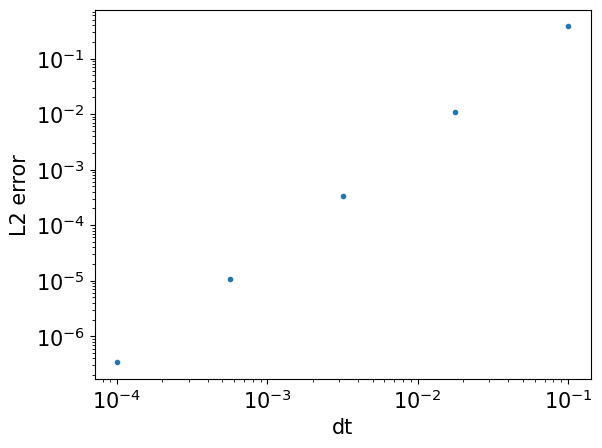

In [85]:
fig, ax = plt.subplots()
ax.loglog(dt_range, err, '.')
ax.set(xlabel='dt', ylabel='L2 error')

[Text(0.5, 0, 'dt'), Text(0, 0.5, 'L2 error')]

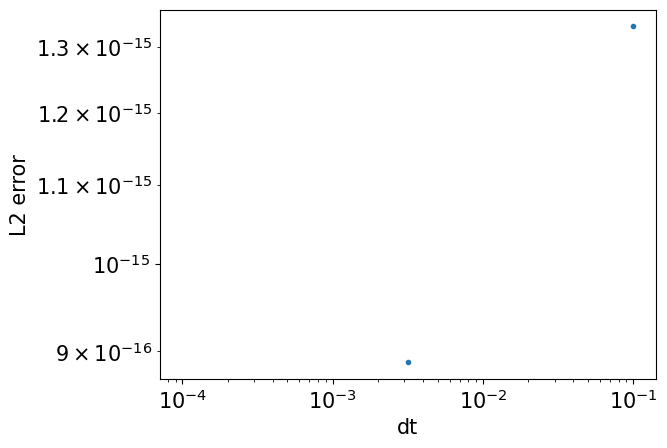

In [92]:
fig, ax = plt.subplots()
ax.loglog(dt_range, err, '.')
ax.set(xlabel='dt', ylabel='L2 error')